In [34]:
import nltk
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import brown, treebank, conll2000
from nltk.probability import ConditionalFreqDist, ConditionalProbDist, FreqDist

In [11]:
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')

[nltk_data] Downloading package brown to /home/halas/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package treebank to /home/halas/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package conll2000 to /home/halas/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/halas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/halas/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [13]:
txt = brown.tagged_words(tagset='universal') + \
    treebank.tagged_words(tagset='universal') + \
    conll2000.tagged_words(tagset='universal')

In [14]:
tokens = [(tup[0].lower(), tup[1]) for tup in txt]

# Make a word-frequency dict
counter = Counter(tokens)
word_freq = {}
for (k1, k2), value in counter.items():
    if k1 not in word_freq:
        word_freq[k1] = {}
    word_freq[k1][k2] = value

In [15]:
pos_lst = [tup[1] for tup in tokens]

In [24]:
round(1.426, 2)

1.43

In [25]:
def pos_predict(s, assignment, threshold):
    if len(assignment) == len(s):
        # Base case: assignment is returned if it is complete
        return assignment
    
    var = s[len(assignment)].lower()
    var_fdist = FreqDist(word_freq[var])
    var_freq = var_fdist.most_common() # Ordered by descending frequency
            
    for pos in var_freq:
        # for each tag, append it to assignment
        assignment.append(pos[0])
        
        valid = True
        if len(assignment) > 1:
            # Check if curr sequence of POS predictions match the frequencies from the text
            window = len(assignment)
            ngrams = list(nltk.ngrams(pos_lst, window))
            cfdist = ConditionalFreqDist((tuple(x[-1 * window:-1]), x[-1]) for x in ngrams)
            cpdist = ConditionalProbDist(cfdist, nltk.MLEProbDist)

            fdist = cpdist[tuple(assignment[-1 * window:-1])].freqdist()
            cond_prob = fdist.freq(assignment[-1])
            
            surpr = (-1 * np.log2(max(0.00001, cond_prob))) / (window - 1)
            print(assignment[-1 * window:-1], assignment[-1], surpr)
            if round(surpr, 2) >= threshold:
                valid = False
        
        # predict the rest of the sentence based on curr tag
        if valid:
            res = pos_predict(s, assignment, threshold)
            if len(res) > 0:
                return res
        
        # if assignment is fault, pop and try others
        assignment.pop()
    
    return []

In [17]:
def backtrack_model(sentences, threshold):
    pred = []
    for i in tqdm(range(len(sentences))):
        p = pos_predict(sentences[i], [], threshold)
        print(p)
        pred.append(p)
    return pred

In [18]:
def accuracy(preds, labels):
    accuracies = []
    for i in range(len(preds)):
        actual = labels[i]
        acc = 0
        for j in range(len(preds[i])):
            if preds[i][j] == actual[j]:
                acc += 1
        if len(preds[i]) > 0:
            acc = acc / len(preds[i])
        accuracies.append(acc)
    return accuracies

In [26]:
f = open('data/data_garden.txt')
lines = f.readlines()[:12]
data = []
for line in lines:
    tokens = line.split()
    tokens =  [t.lower() for t in tokens]
    data.append(tokens)
    
f_out = open('data/labels_garden.txt')
lines_out = f_out.readlines()[:12]
labels = []
for line in lines_out:
    tokens = line.split()
    labels.append(tokens)

sup_range = np.arange(1.3, 2, 0.05)
dct = {}
for num in tqdm(sup_range):
    pred = backtrack_model(data, num)
    acc = accuracy(pred, labels)
    dct[num] = (np.mean(acc), acc)

  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] DET 1.0484590083886116
['DET', 'NOUN', 'VERB', 'DET'] NOUN 0.1895980379943832



  8%|███████                                                                             | 1/12 [00:11<02:07, 11.57s/it]

['DET', 'NOUN', 'VERB', 'DET', 'NOUN'] . 0.49417393894631945
['DET', 'NOUN', 'VERB', 'DET', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADJ 1.2763297650595449



 17%|██████████████                                                                      | 2/12 [00:17<01:22,  8.23s/it]

['DET', 'NOUN', 'VERB', 'ADJ'] . 0.4025583207266306
['DET', 'NOUN', 'VERB', 'ADJ', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ'] VERB 5.9739875644691125
['NOUN'] NOUN 2.462371917922164



 25%|█████████████████████                                                               | 3/12 [00:22<01:00,  6.73s/it]

['NOUN'] VERB 2.677866308408386
[]
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['ADP'] NOUN 1.8862377954163474
['NOUN'] NOUN 2.462371917922164
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] NOUN 1.559643542729314
['X'] NOUN 3.980100442562295



 33%|████████████████████████████                                                        | 4/12 [00:29<00:55,  6.98s/it]

['NUM'] NOUN 1.4372102170190268
[]
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET'] ADJ 2.105399664405011
['ADP'] NOUN 1.8862377954163474
['ADP'] ADJ 3.544251990535275
['NOUN'] NOUN 2.462371917922164
['NOUN'] ADJ 6.2570809646116095
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] NOUN 1.559643542729314
['ADJ'] ADJ 4.060095620358559
['X'] NOUN 3.980100442562295
['X'] ADJ 6.119298928372344
['NUM'] NOUN 1.4372102170190268



 42%|███████████████████████████████████                                                 | 5/12 [00:44<01:07,  9.66s/it]

['NUM'] ADJ 4.341852827832495
[]
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB'] PRON 2.0644088936450173
['NOUN'] VERB 2.677866308408386



 50%|██████████████████████████████████████████                                          | 6/12 [00:49<00:49,  8.24s/it]

['X'] VERB 2.4995216570560284
[]
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] DET 1.0484590083886116
['DET', 'NOUN', 'VERB', 'DET'] ADJ 0.45836653594769167



 58%|█████████████████████████████████████████████████                                   | 7/12 [00:58<00:41,  8.31s/it]

['DET', 'NOUN', 'VERB', 'DET', 'ADJ'] . 0.8598731880470541
['DET', 'NOUN', 'VERB', 'DET', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] VERB 0.5954520042873993
['DET', 'NOUN', 'VERB', 'VERB'] CONJ 1.3025706847646132
['DET', 'NOUN', 'VERB', 'VERB'] X 1.4337810618355096
['DET', 'NOUN', 'VERB', 'VERB'] ADJ 1.009237784043223
['DET', 'NOUN', 'VERB', 'VERB', 'ADJ'] ADJ 0.9981909720793987
['DET', 'NOUN', 'VERB', 'VERB', 'ADJ', 'ADJ'] NOUN 0.025333848907508325
['DET', 'NOUN', 'VERB', 'VERB', 'ADJ', 'ADJ', 'NOUN'] . 0.30998928592033037



 67%|████████████████████████████████████████████████████████                            | 8/12 [01:18<00:48, 12.04s/it]

['DET', 'NOUN', 'VERB', 'VERB', 'ADJ', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512269326928693
['DET', 'NOUN', 'VERB', 'ADV'] PRON 1.67438670137992
['DET', 'NOUN', 'VERB', 'ADV'] PRT 1.3955173970249362
['ADP'] NOUN 1.8862377954163474
['NOUN'] NOUN 2.462371917922164
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] NOUN 1.559643542729314
['ADJ', 'NOUN'] VERB 1.4156966328385077
['X'] NOUN 3.980100442562295



 75%|███████████████████████████████████████████████████████████████                     | 9/12 [01:31<00:37, 12.48s/it]

['NUM'] NOUN 1.4372102170190268
[]
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['ADP'] ADJ 3.544251990535275
['ADP'] NOUN 1.8862377954163474
['NOUN'] ADJ 6.2570809646116095
['NOUN'] NOUN 2.462371917922164
['ADJ'] ADJ 4.060095620358559
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] NOUN 1.559643542729314
['X'] ADJ 6.119298928372344
['X'] NOUN 3.980100442562295
['NUM'] ADJ 4.341852827832495



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [01:44<00:25, 12.60s/it]

['NUM'] NOUN 1.4372102170190268
[]
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [01:51<00:10, 10.96s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



  7%|█████▉                                                                             | 1/14 [01:53<24:34, 113.46s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] DET 1.0484590083886116
['DET', 'NOUN', 'VERB', 'DET'] NOUN 0.1895980379943832



  8%|███████                                                                             | 1/12 [00:07<01:25,  7.75s/it]

['DET', 'NOUN', 'VERB', 'DET', 'NOUN'] . 0.49417393894631945
['DET', 'NOUN', 'VERB', 'DET', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADJ 1.2763297650595449



 17%|██████████████                                                                      | 2/12 [00:15<01:14,  7.47s/it]

['DET', 'NOUN', 'VERB', 'ADJ'] . 0.4025583207266306
['DET', 'NOUN', 'VERB', 'ADJ', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ'] VERB 5.9739875644691125
['NOUN'] NOUN 2.462371917922164



 25%|█████████████████████                                                               | 3/12 [00:20<00:57,  6.41s/it]

['NOUN'] VERB 2.677866308408386
[]
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['ADP'] NOUN 1.8862377954163474
['NOUN'] NOUN 2.462371917922164
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] NOUN 1.559643542729314
['X'] NOUN 3.980100442562295



 33%|████████████████████████████                                                        | 4/12 [00:28<00:55,  6.99s/it]

['NUM'] NOUN 1.4372102170190268
[]
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET'] ADJ 2.105399664405011
['ADP'] NOUN 1.8862377954163474
['ADP'] ADJ 3.544251990535275
['NOUN'] NOUN 2.462371917922164
['NOUN'] ADJ 6.2570809646116095
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] NOUN 1.559643542729314
['ADJ'] ADJ 4.060095620358559
['X'] NOUN 3.980100442562295
['X'] ADJ 6.119298928372344
['NUM'] NOUN 1.4372102170190268



 42%|███████████████████████████████████                                                 | 5/12 [00:41<01:04,  9.20s/it]

['NUM'] ADJ 4.341852827832495
[]
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB'] PRON 2.0644088936450173
['NOUN'] VERB 2.677866308408386



 50%|██████████████████████████████████████████                                          | 6/12 [00:46<00:46,  7.72s/it]

['X'] VERB 2.4995216570560284
[]
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] DET 1.0484590083886116
['DET', 'NOUN', 'VERB', 'DET'] ADJ 0.45836653594769167



 58%|█████████████████████████████████████████████████                                   | 7/12 [00:54<00:40,  8.01s/it]

['DET', 'NOUN', 'VERB', 'DET', 'ADJ'] . 0.8598731880470541
['DET', 'NOUN', 'VERB', 'DET', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] VERB 0.5954520042873993
['DET', 'NOUN', 'VERB', 'VERB'] CONJ 1.3025706847646132
['DET', 'NOUN', 'VERB', 'VERB', 'CONJ'] ADJ 0.8279102704797587
['DET', 'NOUN', 'VERB', 'VERB', 'CONJ', 'ADJ'] NOUN 0.5
['DET', 'NOUN', 'VERB', 'VERB', 'CONJ', 'ADJ', 'NOUN'] . 2.3728057820624016
['DET', 'NOUN', 'VERB', 'VERB', 'CONJ'] NOUN 1.0279102704797587
['DET', 'NOUN', 'VERB', 'VERB', 'CONJ', 'NOUN'] NOUN 0.3333333333333333
['DET', 'NOUN', 'VERB', 'VERB', 'CONJ', 'NOUN', 'NOUN'] . 2.3728057820624016
['DET', 'NOUN', 'VERB', 'VERB', 'CONJ'] VERB 0.25631407145424434
['DET', 'NOUN', 'VERB', 'VERB', 'CONJ', 'VERB'] NOUN 0.712169749067736
['DET', 'NOUN', 'VERB', 'VERB', 'CONJ', 'VERB', 'NOUN'] . 2.3728057820624016
['DET', 'NOUN', 'VERB', 'VERB'] X


 67%|████████████████████████████████████████████████████████                            | 8/12 [01:43<01:23, 20.91s/it]

['DET', 'NOUN', 'VERB', 'VERB', 'ADJ', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512269326928693
['DET', 'NOUN', 'VERB', 'ADV'] PRON 1.67438670137992
['DET', 'NOUN', 'VERB', 'ADV'] PRT 1.3955173970249362
['ADP'] NOUN 1.8862377954163474
['NOUN'] NOUN 2.462371917922164
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] NOUN 1.559643542729314
['ADJ', 'NOUN'] VERB 1.4156966328385077
['X'] NOUN 3.980100442562295



 75%|███████████████████████████████████████████████████████████████                     | 9/12 [01:56<00:55, 18.50s/it]

['NUM'] NOUN 1.4372102170190268
[]
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['ADP'] ADJ 3.544251990535275
['ADP'] NOUN 1.8862377954163474
['NOUN'] ADJ 6.2570809646116095
['NOUN'] NOUN 2.462371917922164
['ADJ'] ADJ 4.060095620358559
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] NOUN 1.559643542729314
['X'] ADJ 6.119298928372344
['X'] NOUN 3.980100442562295
['NUM'] ADJ 4.341852827832495



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [02:09<00:33, 16.80s/it]

['NUM'] NOUN 1.4372102170190268
[]
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [02:16<00:13, 13.88s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 14%|███████████▊                                                                       | 2/14 [04:11<25:38, 128.17s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:07<01:24,  7.67s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:13<01:06,  6.65s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ'] VERB 5.9739875644691125
['NOUN'] NOUN 2.462371917922164



 25%|█████████████████████                                                               | 3/12 [00:18<00:51,  5.72s/it]

['NOUN'] VERB 2.677866308408386
[]
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] PRT 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] NOUN 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'NOUN'] NOUN 2.0762050593046015
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADV 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] X 2.3728057820624016
['DET', 'NOUN', '


 33%|████████████████████████████                                                        | 4/12 [01:35<04:32, 34.01s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADV', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADP 1.568565415314262
['DET', 'NOUN', 'NOUN', 'ADP'] PRT 1.6845521902542095
['DET', 'NOUN', 'NOUN', 'ADP'] ADV 1.6271817287235177
['DET', 'NOUN', 'NOUN', 'ADP'] X 2.0341895343767784
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] NOUN 0.3464785728752764



 42%|███████████████████████████████████                                                 | 5/12 [01:50<03:08, 27.00s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN'] . 0.2348271641448599
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.']
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB'] PRON 2.0644088936450173
['NOUN'] VERB 2.677866308408386



 50%|██████████████████████████████████████████                                          | 6/12 [01:54<01:56, 19.38s/it]

['X'] VERB 2.4995216570560284
[]
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [02:02<01:17, 15.45s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB'] ADJ 1.0075518282806117
['DET', 'NOUN', 'NOUN', 'VERB', 'ADJ'] ADJ 1.0526068811667586
['DET', 'NOUN', 'NOUN', 'VERB', 'ADJ', 'ADJ'] NOUN 0.053654682481227046
['DET', 'NOUN', 'NOUN', 'VERB', 'ADJ', 'ADJ', 'NOUN'] . 0.2857142857142857



 67%|████████████████████████████████████████████████████████                            | 8/12 [02:19<01:04, 16.07s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'ADJ', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512269326928693
['DET', 'NOUN', 'VERB', 'ADV'] PRON 1.67438670137992
['DET', 'NOUN', 'VERB', 'ADV'] PRT 1.3955173970249362
['DET', 'NOUN', 'VERB', 'ADV', 'PRT'] VERB 0.14008794362821841
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB'] VERB 0.3333333333333333
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB'] . 0.2857142857142857



 75%|███████████████████████████████████████████████████████████████                     | 9/12 [02:38<00:50, 16.85s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [02:46<00:28, 14.11s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [02:53<00:12, 12.07s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 21%|█████████████████▊                                                                 | 3/14 [07:07<27:26, 149.70s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:08<01:34,  8.58s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:15<01:16,  7.65s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:28<01:32, 10.28s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] PRT 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] NOUN 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'NOUN'] NOUN 2.0762050593046015
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADV 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] X 2.3728057820


 33%|████████████████████████████                                                        | 4/12 [01:43<04:43, 35.47s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADV', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADP 1.568565415314262
['DET', 'NOUN', 'NOUN', 'ADP'] PRT 1.6845521902542095
['DET', 'NOUN', 'NOUN', 'ADP'] ADV 1.6271817287235177
['DET', 'NOUN', 'NOUN', 'ADP'] X 2.0341895343767784
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] NOUN 0.3464785728752764



 42%|███████████████████████████████████                                                 | 5/12 [01:58<03:18, 28.36s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN'] . 0.2348271641448599
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.']
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937



 50%|██████████████████████████████████████████                                          | 6/12 [02:08<02:11, 21.99s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [02:16<01:26, 17.34s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN'] . -0.0



 67%|████████████████████████████████████████████████████████                            | 8/12 [02:39<01:16, 19.12s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512269326928693
['DET', 'NOUN', 'VERB', 'ADV'] PRON 1.67438670137992
['DET', 'NOUN', 'VERB', 'ADV'] PRT 1.3955173970249362
['DET', 'NOUN', 'VERB', 'ADV', 'PRT'] VERB 0.14008794362821841
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB'] VERB 0.3333333333333333
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB'] . 0.2857142857142857



 75%|███████████████████████████████████████████████████████████████                     | 9/12 [03:17<01:15, 25.04s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [03:24<00:39, 19.62s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [03:31<00:15, 15.76s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 29%|███████████████████████▋                                                           | 4/14 [10:40<29:08, 174.86s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:07<01:18,  7.17s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:12<01:02,  6.27s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:26<01:25,  9.47s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] PRT 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] NOUN 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'NOUN'] NOUN 2.0762050593046015
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADV 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] X 2.3728057820


 33%|████████████████████████████                                                        | 4/12 [02:19<06:43, 50.39s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADV', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADP 1.568565415314262
['DET', 'NOUN', 'NOUN', 'ADP'] PRT 1.6845521902542095
['DET', 'NOUN', 'NOUN', 'ADP'] ADV 1.6271817287235177
['DET', 'NOUN', 'NOUN', 'ADP'] X 2.0341895343767784
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] NOUN 0.3464785728752764
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN'] . 0.2348271641448599



 42%|███████████████████████████████████                                                 | 5/12 [02:35<04:25, 37.96s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.']
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937



 50%|██████████████████████████████████████████                                          | 6/12 [02:43<02:47, 27.90s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [02:52<01:48, 21.63s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN'] . -0.0



 67%|████████████████████████████████████████████████████████                            | 8/12 [03:08<01:19, 19.94s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512269326928693
['DET', 'NOUN', 'VERB', 'ADV'] PRON 1.67438670137992
['DET', 'NOUN', 'VERB', 'ADV'] PRT 1.3955173970249362
['DET', 'NOUN', 'VERB', 'ADV', 'PRT'] VERB 0.14008794362821841
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB'] VERB 0.3333333333333333
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB'] . 0.2857142857142857



 75%|███████████████████████████████████████████████████████████████                     | 9/12 [03:24<00:56, 18.80s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [03:32<00:30, 15.42s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [03:40<00:12, 12.98s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 36%|█████████████████████████████▋                                                     | 5/14 [14:22<28:46, 191.84s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:08<01:30,  8.24s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:14<01:09,  6.97s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:29<01:37, 10.80s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] PRT 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] NOUN 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'NOUN'] NOUN 2.0762050593046015
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADV 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] X 2.3728057820


 33%|████████████████████████████                                                        | 4/12 [02:13<06:19, 47.40s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADV', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADP 1.568565415314262
['DET', 'NOUN', 'NOUN', 'ADP'] PRT 1.6845521902542095
['DET', 'NOUN', 'NOUN', 'ADP'] ADV 1.6271817287235177
['DET', 'NOUN', 'NOUN', 'ADP'] X 2.0341895343767784
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] NOUN 0.3464785728752764
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN'] . 0.2348271641448599



 42%|███████████████████████████████████                                                 | 5/12 [02:35<04:28, 38.32s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.']
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736



 50%|██████████████████████████████████████████                                          | 6/12 [02:51<03:04, 30.70s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [03:00<01:57, 23.53s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN'] . -0.0



 67%|████████████████████████████████████████████████████████                            | 8/12 [03:17<01:26, 21.59s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512269326928693
['DET', 'NOUN', 'VERB', 'ADV'] PRON 1.67438670137992
['DET', 'NOUN', 'VERB', 'ADV'] PRT 1.3955173970249362
['DET', 'NOUN', 'VERB', 'ADV', 'PRT'] VERB 0.14008794362821841
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB'] VERB 0.3333333333333333
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB'] . 0.2857142857142857



 75%|███████████████████████████████████████████████████████████████                     | 9/12 [03:37<01:03, 21.05s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [03:45<00:34, 17.19s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [03:53<00:14, 14.26s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 43%|███████████████████████████████████▌                                               | 6/14 [18:18<27:33, 206.67s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:07<01:26,  7.88s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:14<01:10,  7.07s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:29<01:37, 10.78s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] PRT 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] NOUN 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'NOUN'] NOUN 2.0762050593046015
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADV 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] X 2.3728057820


 33%|████████████████████████████                                                        | 4/12 [01:47<04:58, 37.30s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADV', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADP 1.568565415314262
['DET', 'NOUN', 'NOUN', 'ADP', 'ADP'] NOUN 0.6643856189774724
['DET', 'NOUN', 'NOUN', 'ADP', 'ADP', 'NOUN'] . 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADP'] PRT 1.6845521902542095
['DET', 'NOUN', 'NOUN', 'ADP'] ADV 1.6271817287235177
['DET', 'NOUN', 'NOUN', 'ADP'] X 2.0341895343767784
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] NOUN 0.3464785728752764



 42%|███████████████████████████████████                                                 | 5/12 [02:08<03:40, 31.43s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN'] . 0.2348271641448599
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.']
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937



 50%|██████████████████████████████████████████                                          | 6/12 [02:19<02:25, 24.29s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']


['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [02:26<01:34, 18.92s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN'] . -0.0



 67%|████████████████████████████████████████████████████████                            | 8/12 [02:41<01:10, 17.60s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512269326928693
['DET', 'NOUN', 'VERB', 'ADV'] PRON 1.67438670137992
['DET', 'NOUN', 'VERB', 'ADV'] PRT 1.3955173970249362
['DET', 'NOUN', 'VERB', 'ADV', 'PRT'] VERB 0.14008794362821841
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB'] VERB 0.3333333333333333
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB'] . 0.2857142857142857



 75%|███████████████████████████████████████████████████████████████                     | 9/12 [02:59<00:52, 17.63s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [03:06<00:29, 14.54s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [03:14<00:12, 12.28s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 50%|█████████████████████████████████████████▌                                         | 7/14 [21:33<23:42, 203.15s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:07<01:23,  7.61s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:13<01:06,  6.60s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:27<01:30, 10.06s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] PRT 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] NOUN 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'NOUN'] NOUN 2.0762050593046015
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADV 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] X 2.3728057820


 33%|████████████████████████████                                                        | 4/12 [01:48<05:04, 38.03s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADV', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADP 1.568565415314262
['DET', 'NOUN', 'NOUN', 'ADP', 'ADP'] NOUN 0.6643856189774724
['DET', 'NOUN', 'NOUN', 'ADP', 'ADP', 'NOUN'] . 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADP'] PRT 1.6845521902542095
['DET', 'NOUN', 'NOUN', 'ADP'] ADV 1.6271817287235177
['DET', 'NOUN', 'NOUN', 'ADP', 'ADV'] NOUN 0.7005000681058366
['DET', 'NOUN', 'NOUN', 'ADP', 'ADV', 'NOUN'] . 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADP'] X 2.0341895343767784
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] NOUN 0.3464785728752764



 42%|███████████████████████████████████                                                 | 5/12 [02:14<03:56, 33.81s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN'] . 0.2348271641448599
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', 'NOUN', '.']
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937



 50%|██████████████████████████████████████████                                          | 6/12 [02:24<02:33, 25.62s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [02:32<01:38, 19.72s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN'] . -0.0



 67%|████████████████████████████████████████████████████████                            | 8/12 [02:47<01:13, 18.32s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512269326928693
['DET', 'NOUN', 'VERB', 'ADV'] PRON 1.67438670137992
['DET', 'NOUN', 'VERB', 'ADV'] PRT 1.3955173970249362
['DET', 'NOUN', 'VERB', 'ADV', 'PRT'] VERB 0.14008794362821841
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB'] VERB 0.3333333333333333



 75%|███████████████████████████████████████████████████████████████                     | 9/12 [03:05<00:54, 18.18s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB'] . 0.2857142857142857
['DET', 'NOUN', 'VERB', 'ADV', 'PRT', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [03:13<00:30, 15.03s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [03:20<00:12, 12.72s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 57%|███████████████████████████████████████████████▍                                   | 8/14 [24:56<20:18, 203.02s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:07<01:27,  7.95s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:13<01:07,  6.73s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:27<01:30, 10.00s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] PRT 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] NOUN 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'NOUN'] NOUN 2.0762050593046015
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADV 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] X 2.3728057820


 33%|████████████████████████████                                                        | 4/12 [01:42<04:45, 35.70s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADV', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADP 1.568565415314262
['DET', 'NOUN', 'NOUN', 'ADP', 'ADP'] NOUN 0.6643856189774724
['DET', 'NOUN', 'NOUN', 'ADP', 'ADP', 'NOUN'] . 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADP'] PRT 1.6845521902542095
['DET', 'NOUN', 'NOUN', 'ADP', 'PRT'] NOUN 0.5715961990255145
['DET', 'NOUN', 'NOUN', 'ADP', 'PRT', 'NOUN'] . 0.16666666666666666



 42%|███████████████████████████████████                                                 | 5/12 [02:01<03:26, 29.46s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'PRT', 'NOUN', '.']
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937



 50%|██████████████████████████████████████████                                          | 6/12 [02:11<02:17, 22.90s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [02:19<01:30, 18.02s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN'] . -0.0



 67%|████████████████████████████████████████████████████████                            | 8/12 [02:36<01:10, 17.63s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512269326928693
['DET', 'NOUN', 'VERB', 'ADV'] PRON 1.67438670137992
['DET', 'NOUN', 'VERB', 'ADV', 'PRON'] VERB 0.0251061764167718
['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB'] VERB 0.3562505872916559



 75%|███████████████████████████████████████████████████████████████                     | 9/12 [02:51<00:50, 16.85s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB', 'VERB'] . 0.33170401355533746
['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [02:59<00:28, 14.06s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [03:06<00:12, 12.04s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 64%|█████████████████████████████████████████████████████▎                             | 9/14 [28:05<16:32, 198.53s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:07<01:27,  7.92s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:14<01:11,  7.18s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:28<01:33, 10.41s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] PRT 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] NOUN 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'NOUN'] NOUN 2.0762050593046015
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADV 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] X 2.3728057820


 33%|████████████████████████████                                                        | 4/12 [01:47<04:57, 37.24s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADV', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN', 'PRT'] ADP 1.2314998546390559
['DET', 'NOUN', 'NOUN', 'PRT', 'ADP'] NOUN 0.5813781191217038
['DET', 'NOUN', 'NOUN', 'PRT', 'ADP', 'NOUN'] . 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'PRT'] PRT 2.2082225035411853
['DET', 'NOUN', 'NOUN', 'PRT'] ADV 1.6277404798193449
['DET', 'NOUN', 'NOUN', 'PRT', 'ADV'] NOUN 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'PRT'] X 4.152410118609203
['DET', 'NOUN', 'NOUN', 'PRT'] NOUN 0.461051331848144
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN'] NOUN 0.4068976752770581



 42%|███████████████████████████████████                                                 | 5/12 [02:09<03:44, 32.00s/it]

['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN'] . 0.19114023138821187
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN', '.']
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937



 50%|██████████████████████████████████████████                                          | 6/12 [02:19<02:26, 24.34s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [02:27<01:34, 18.89s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] ADJ 0.9287712379549449
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'ADJ'] NOUN 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] NOUN 0.6117787378107138
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'NOUN'] NOUN 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] VERB 0.14739311883324124
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'VERB'] NOUN 0.6511484326014197
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'VERB', 'NOUN'] . 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', '


 67%|████████████████████████████████████████████████████████                            | 8/12 [03:00<01:34, 23.57s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512269326928693
['DET', 'NOUN', 'VERB', 'ADV'] PRON 1.67438670137992
['DET', 'NOUN', 'VERB', 'ADV', 'PRON'] VERB 0.0251061764167718
['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB'] VERB 0.3562505872916559
['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB', 'VERB'] . 0.33170401355533746



 75%|███████████████████████████████████████████████████████████████                     | 9/12 [03:14<01:01, 20.63s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [03:22<00:33, 16.69s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [03:29<00:13, 13.82s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 71%|██████████████████████████████████████████████████████████▌                       | 10/14 [31:37<13:30, 202.62s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:07<01:21,  7.43s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:13<01:07,  6.74s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:27<01:29,  9.98s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] PRT 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] NOUN 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'NOUN'] NOUN 2.0762050593046015
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADV 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] X 2.3728057820


 33%|████████████████████████████                                                        | 4/12 [01:44<04:51, 36.49s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADV', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN', 'PRT'] ADP 1.2314998546390559
['DET', 'NOUN', 'NOUN', 'PRT', 'ADP'] NOUN 0.5813781191217038
['DET', 'NOUN', 'NOUN', 'PRT', 'ADP', 'NOUN'] . 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'PRT'] PRT 2.2082225035411853
['DET', 'NOUN', 'NOUN', 'PRT'] ADV 1.6277404798193449
['DET', 'NOUN', 'NOUN', 'PRT', 'ADV'] NOUN 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'PRT'] X 4.152410118609203
['DET', 'NOUN', 'NOUN', 'PRT'] NOUN 0.461051331848144
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN'] NOUN 0.4068976752770581
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN'] . 0.19114023138821187
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN', '.']



 42%|███████████████████████████████████                                                 | 5/12 [02:06<03:39, 31.31s/it]

['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937



 50%|██████████████████████████████████████████                                          | 6/12 [02:15<02:21, 23.60s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [02:24<01:33, 18.72s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] ADJ 0.9287712379549449
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'ADJ'] NOUN 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] NOUN 0.6117787378107138
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'NOUN'] NOUN 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] VERB 0.14739311883324124
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'VERB'] NOUN 0.6511484326014197
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'VERB', 'NOUN'] . 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0



 67%|████████████████████████████████████████████████████████                            | 8/12 [02:59<01:35, 23.92s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN'] . -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN', 'NOUN', 'ADV'] PRON 0.89811425931702
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] VERB 0.018621880878296294
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'VERB'] VERB 0.3869880158145604
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'VERB', 'VERB'] . 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] NOUN 1.0
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'NOUN'] VERB 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] X 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'ADV'] PRT 1.3176322355951795
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] VERB 0.14739311883324124
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT', 'VERB'] VERB 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] NOUN 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] X 3.3219280948873626
['DET', 'NOUN']


 75%|███████████████████████████████████████████████████████████████                     | 9/12 [03:39<01:26, 28.93s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [03:46<00:44, 22.41s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [03:54<00:17, 17.76s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 79%|████████████████████████████████████████████████████████████████▍                 | 11/14 [35:33<10:38, 212.87s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:07<01:22,  7.51s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:13<01:05,  6.50s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:27<01:30, 10.03s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757



 33%|████████████████████████████                                                        | 4/12 [00:53<02:11, 16.46s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN', 'PRT'] ADP 1.2314998546390559
['DET', 'NOUN', 'NOUN', 'PRT', 'ADP'] NOUN 0.5813781191217038
['DET', 'NOUN', 'NOUN', 'PRT', 'ADP', 'NOUN'] . 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'PRT'] PRT 2.2082225035411853
['DET', 'NOUN', 'NOUN', 'PRT'] ADV 1.6277404798193449
['DET', 'NOUN', 'NOUN', 'PRT', 'ADV'] NOUN 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'PRT'] X 4.152410118609203
['DET', 'NOUN', 'NOUN', 'PRT'] NOUN 0.461051331848144
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN'] NOUN 0.4068976752770581



 42%|███████████████████████████████████                                                 | 5/12 [01:13<02:02, 17.43s/it]

['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN'] . 0.19114023138821187
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN', '.']
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937



 50%|██████████████████████████████████████████                                          | 6/12 [01:21<01:27, 14.54s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [01:29<01:00, 12.17s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] ADJ 0.9287712379549449
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'ADJ'] NOUN 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] NOUN 0.6117787378107138
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'NOUN'] NOUN 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] VERB 0.14739311883324124
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'VERB'] NOUN 0.6511484326014197
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'VERB', 'NOUN'] . 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0



 67%|████████████████████████████████████████████████████████                            | 8/12 [02:02<01:15, 18.77s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN'] . -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN', 'NOUN', 'ADV'] PRON 0.89811425931702
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] VERB 0.018621880878296294
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'VERB'] VERB 0.3869880158145604
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'VERB', 'VERB'] . 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] NOUN 1.0
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'NOUN'] VERB 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] X 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'ADV'] PRT 1.3176322355951795
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] VERB 0.14739311883324124
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT', 'VERB'] VERB 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] NOUN 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] X 3.3219280948873626
['DET', 'NOUN']


 75%|███████████████████████████████████████████████████████████████                     | 9/12 [02:42<01:16, 25.40s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [02:49<00:39, 19.78s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [02:56<00:15, 15.89s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474



 86%|██████████████████████████████████████████████████████████████████████▎           | 12/14 [38:31<06:44, 202.30s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:07<01:20,  7.33s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:13<01:03,  6.40s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:27<01:29,  9.96s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757



 33%|████████████████████████████                                                        | 4/12 [00:53<02:10, 16.29s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN', 'PRT'] ADP 1.2314998546390559
['DET', 'NOUN', 'NOUN', 'PRT', 'ADP'] NOUN 0.5813781191217038
['DET', 'NOUN', 'NOUN', 'PRT', 'ADP', 'NOUN'] . 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'PRT'] PRT 2.2082225035411853
['DET', 'NOUN', 'NOUN', 'PRT'] ADV 1.6277404798193449
['DET', 'NOUN', 'NOUN', 'PRT', 'ADV'] NOUN 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'PRT'] X 4.152410118609203
['DET', 'NOUN', 'NOUN', 'PRT'] NOUN 0.461051331848144
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN'] NOUN 0.4068976752770581



 42%|███████████████████████████████████                                                 | 5/12 [01:12<02:01, 17.37s/it]

['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN'] . 0.19114023138821187
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN', '.']
['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937



 50%|██████████████████████████████████████████                                          | 6/12 [01:21<01:27, 14.57s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [01:29<01:01, 12.26s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] ADJ 0.9287712379549449
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'ADJ'] NOUN 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] NOUN 0.6117787378107138
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'NOUN'] NOUN 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] VERB 0.14739311883324124
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'VERB'] NOUN 0.6511484326014197
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'VERB', 'NOUN'] . 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', '


 67%|████████████████████████████████████████████████████████                            | 8/12 [02:04<01:18, 19.53s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN', 'NOUN', 'ADV'] PRON 0.89811425931702
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] VERB 0.018621880878296294
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'VERB'] VERB 0.3869880158145604
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'VERB', 'VERB'] . 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] NOUN 1.0
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'NOUN'] VERB 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] X 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'ADV'] PRT 1.3176322355951795
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] VERB 0.14739311883324124
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT', 'VERB'] VERB 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] NOUN 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] X 3.3219280948873626
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512


 75%|███████████████████████████████████████████████████████████████                     | 9/12 [02:48<01:21, 27.18s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [02:56<00:42, 21.29s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [03:03<00:17, 17.04s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474
['ADP', 'NOUN'] ADV 2.8330772918539306



 93%|████████████████████████████████████████████████████████████████████████████▏     | 13/14 [41:37<03:17, 197.54s/it]

['ADV'] NOUN 4.90361231495799
[]



  0%|                                                                                            | 0/12 [00:00<?, ?it/s]

['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] NOUN 0.39000403589773136



  8%|███████                                                                             | 1/12 [00:07<01:27,  7.93s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN'] . 0.3663204936608563
['DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311



 17%|██████████████                                                                      | 2/12 [00:13<01:07,  6.74s/it]

['DET', 'NOUN', 'NOUN', 'NOUN'] . 0.418350116347185
['DET', 'NOUN', 'NOUN', 'NOUN', '.']
['ADJ'] NOUN 0.5924382999268272
['ADJ', 'NOUN'] VERB 1.4156966328385077
['ADJ', 'NOUN', 'VERB'] VERB 0.5855680189875377
['ADJ', 'NOUN', 'VERB', 'VERB'] ADP 0.49963574436201486
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP'] DET 0.22984022303869228
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET'] NOUN 0.10775838315733129
['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN'] . 0.30807206938285586



 25%|█████████████████████                                                               | 3/12 [00:27<01:27,  9.76s/it]

['ADJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'DET', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] VERB 0.4225893275594555
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB'] ADP 0.3918056437887388
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP'] VERB 0.7301369639901552
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB'] ADP 0.36928035724587943
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN'] . 1.845515608270757



 33%|████████████████████████████                                                        | 4/12 [00:52<02:08, 16.06s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'VERB', 'ADP', 'VERB', 'ADP', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] PRT 1.718923525190594
['DET', 'NOUN', 'NOUN', 'PRT'] ADP 1.2314998546390559
['DET', 'NOUN', 'NOUN', 'PRT', 'ADP'] NOUN 0.5813781191217038
['DET', 'NOUN', 'NOUN', 'PRT', 'ADP', 'NOUN'] . 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'PRT'] PRT 2.2082225035411853
['DET', 'NOUN', 'NOUN', 'PRT'] ADV 1.6277404798193449
['DET', 'NOUN', 'NOUN', 'PRT', 'ADV'] NOUN 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'PRT'] X 4.152410118609203
['DET', 'NOUN', 'NOUN', 'PRT'] NOUN 0.461051331848144
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN'] NOUN 0.4068976752770581


['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN'] . 0.19114023138821187
['DET', 'NOUN', 'NOUN', 'PRT', 'NOUN', 'NOUN', '.']


 42%|███████████████████████████████████                                                 | 5/12 [01:13<02:03, 17.66s/it]

['PRON'] VERB 0.5663379905699087
['PRON', 'VERB'] DET 1.4202962703373951
['PRON', 'VERB', 'DET'] NOUN 0.22232911983417958
['PRON', 'VERB', 'DET', 'NOUN'] VERB 0.9832954733568615
['PRON', 'VERB', 'DET', 'NOUN', 'VERB'] ADJ 0.8101252146139937



 50%|██████████████████████████████████████████                                          | 6/12 [01:22<01:28, 14.75s/it]

['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ'] . 0.13455915367626736
['PRON', 'VERB', 'DET', 'NOUN', 'VERB', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] DET 2.0176742169113178
['DET', 'NOUN', 'NOUN'] ADP 0.7978236111973712
['DET', 'NOUN', 'NOUN', 'ADP'] ADJ 0.9862845162413704



 58%|█████████████████████████████████████████████████                                   | 7/12 [01:30<01:02, 12.53s/it]

['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ'] . 1.1302103382357858
['DET', 'NOUN', 'NOUN', 'ADP', 'ADJ', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] VERB 0.7914969252976404
['DET', 'NOUN', 'NOUN', 'VERB'] CONJ 1.7428284060172194
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] ADJ 0.9287712379549449
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'ADJ'] NOUN 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] NOUN 0.6117787378107138
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'NOUN'] NOUN 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ'] VERB 0.14739311883324124
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'VERB'] NOUN 0.6511484326014197
['DET', 'NOUN', 'NOUN', 'VERB', 'CONJ', 'VERB', 'NOUN'] . 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'VERB'] X 1.415243375864182
['DET', 'NOUN', 'NOUN', 'VERB', 'X'] ADJ 1.190839262077375
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ'] NOUN -0.0
['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', '


 67%|████████████████████████████████████████████████████████                            | 8/12 [02:05<01:18, 19.55s/it]

['DET', 'NOUN', 'NOUN', 'VERB', 'X', 'ADJ', 'NOUN', '.']
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADV 1.7990678508228146
['DET', 'NOUN', 'NOUN', 'ADV'] PRON 0.89811425931702
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] VERB 0.018621880878296294
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'VERB'] VERB 0.3869880158145604
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'VERB', 'VERB'] . 2.3728057820624016
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] NOUN 1.0
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON', 'NOUN'] VERB 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADV', 'PRON'] X 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'ADV'] PRT 1.3176322355951795
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] VERB 0.14739311883324124
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT', 'VERB'] VERB 2.7682734124061352
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] NOUN 3.3219280948873626
['DET', 'NOUN', 'NOUN', 'ADV', 'PRT'] X 3.3219280948873626
['DET', 'NOUN'] VERB 1.2823212108167499
['DET', 'NOUN', 'VERB'] ADV 0.9512


 75%|███████████████████████████████████████████████████████████████                     | 9/12 [02:45<01:18, 26.03s/it]

['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB', 'VERB'] . 0.33170401355533746
['DET', 'NOUN', 'VERB', 'ADV', 'PRON', 'VERB', 'VERB', '.']
['DET'] ADJ 2.105399664405011
['DET'] NOUN 0.6707314412944659
['DET', 'NOUN'] NOUN 1.35558596810821
['DET', 'NOUN', 'NOUN'] ADJ 2.1850107873666
['DET', 'NOUN', 'NOUN'] NOUN 0.8504628445372311
['DET', 'NOUN', 'NOUN', 'NOUN'] NOUN 0.5511630948412821



 83%|█████████████████████████████████████████████████████████████████████▏             | 10/12 [02:53<00:40, 20.40s/it]

['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN'] . 0.27888317773255167
['DET', 'NOUN', 'NOUN', 'NOUN', 'NOUN', '.']
['ADP'] PRON 3.8435284728376686
['ADP'] X 8.780237356495702
['NOUN'] PRON 5.952130379420475
['NOUN'] X 8.646521052888762
['VERB'] PRON 4.221552366657197
['VERB'] X 6.288073877108881
['ADJ'] PRON 8.131334499831954



 92%|████████████████████████████████████████████████████████████████████████████       | 11/12 [03:00<00:16, 16.38s/it]

['ADJ'] X 9.240563569586714
[]
['ADP'] NOUN 1.8862377954163474
['ADP', 'NOUN'] ADV 2.8330772918539306



100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [44:41<00:00, 191.51s/it]

['ADV'] NOUN 4.90361231495799
[]


Text(0, 0.5, 'accuracy')

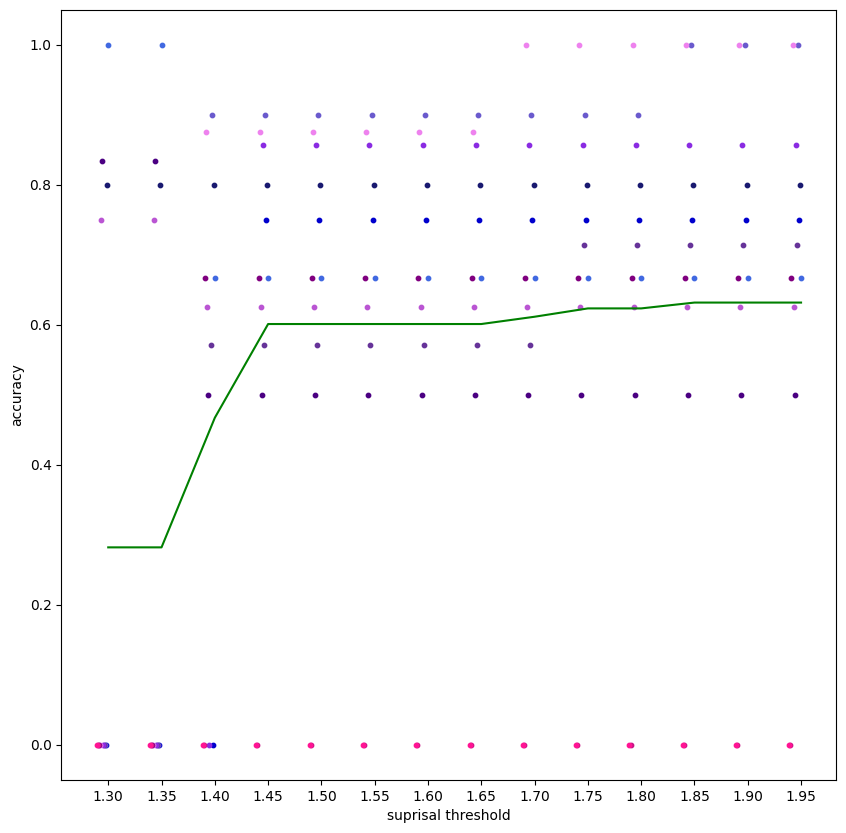

In [67]:
# Plot accuracy values
fig = plt.figure(figsize=(10,10))
t = np.arange(12)
colors = ['royalblue', 'midnightblue', 'mediumblue', 'slateblue', 'rebeccapurple', 'blueviolet', 'indigo',
         'mediumorchid', 'violet', 'purple', 'mediumvioletred', 'deeppink']
for i in t:
    acc = []
    for num in dct:
        acc.append(dct[num][1][i])
    x = [n - (0.001 * i) for n in sup_range]
    plt.scatter(x, acc, color=colors[i], s=10)
#     plt.scatter([num] * len(dct[num][1]), dct[num][1], c=t, cmap="viridis")

# Plot means
means = [dct[num][0] for num in dct]
nums = dct.keys()

plt.plot(nums, means, color='green')
plt.xticks(sup_range)
plt.xlabel("suprisal threshold")
plt.ylabel("accuracy")

In [ ]:
# set range for the surprisal values allowed
# find the value that generates minimal error (grid/line search)
# use normalized suprisal / div by number of elements

In [ ]:
pred = backtrack_model(data, 1.42)
acc = accuracy(pred, labels)